In [ ]:
!wget https://raw.githubusercontent.com/nandakishormpai2001/ship_or_truck_api/model/requirements.txt

In [ ]:
!pip install -r requirements.txt

In [10]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle

In [11]:
class Dataset():
    def __init__(self):
        self.labels,self.images = self.load_data() 

    # To load images and labels for dataloader
    def load_data(self):
        transform_data = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        trainset = torchvision.datasets.CIFAR10(
            root='./', train=True, download=True, transform=transform_data)
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=64, shuffle=True, num_workers=2)

        labels={}
        images = {}
        count = 0
        for batch, (x, y) in enumerate(trainloader):
              for i in range(len(x)):
                  if(y[i] > 7):
                      images[count]=x[i]
                      labels[count]=y[i]-8
                      count+=1
        return labels,images

    def __len__(self):
        return len(self.labels)
    

    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )
        

In [13]:
# Inheriting from Dataset class
class ValDataset(Dataset):

    def load_data(self):
          transform_data = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
          ])

          testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform_data)
          testloader = torch.utils.data.DataLoader(
              testset, batch_size=64, shuffle=False, num_workers=2)
          labels={}
          images = {}
          count = 0
          for batch, (x, y) in enumerate(testloader):
              for i in range(len(x)):
                  if(y[i] > 7):
                      images[count]=x[i]
                      labels[count]=y[i]-8
                      count+=1
          return labels,images


In [15]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # CNNs for rgb images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        # Connecting CNN outputs with Fully Connected layers
        self.fc1 = nn.Linear(in_features=12*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=1)

    def forward(self, t):
        t = t

        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.reshape(-1, 12*5*5)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)

        t = torch.sigmoid(self.out(t))

        return t

In [16]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds,labels):
    return torch.round(preds).eq(labels).sum().item()

In [24]:
def train(model):
    model.train()

    # Defining the loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 15
    epochs = []
    losses = []
    # dataloader in pytorch to load validation and train dataset
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
    testloader = torch.utils.data.DataLoader(valdataset, batch_size=32,shuffle=True)
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        tot_test = 0
        for batch, (x, y) in enumerate(trainloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            y=(torch.unsqueeze(y, 1)).to(torch.float32)
            # Compute loss (here CrossEntropyLoss)
            loss = F.binary_cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(testloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                y=(torch.unsqueeze(y, 1)).to(torch.float32)
                loss = F.binary_cross_entropy(y_pred,y)

            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
            tot_test+= len(y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch," accuracy",round(((tot_correct/tot_test)*100),2)," total_correct",tot_correct," loss:",tot_loss)
        torch.save(model.state_dict(), "models/model001_ep"+str(epoch+1)+".pth")

    # Plot a Validation Loss vs Epochs graph 
    plt.plot(epochs, losses, color='green', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=8) 
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' ) 
    plt.ylabel('loss ------>',color='m',fontsize='xx-large') 
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='tomato')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

In [22]:
dataset = Dataset()
valdataset = ValDataset()

Files already downloaded and verified
Files already downloaded and verified


Epoch 0  accuracy 85.05  total_correct 1701  loss: 22.095546305179596
Epoch 1  accuracy 88.75  total_correct 1775  loss: 17.54895420372486
Epoch 2  accuracy 87.65  total_correct 1753  loss: 17.357545241713524
Epoch 3  accuracy 88.45  total_correct 1769  loss: 17.87438704073429
Epoch 4  accuracy 91.4  total_correct 1828  loss: 13.435674499720335
Epoch 5  accuracy 89.55  total_correct 1791  loss: 18.03157689422369
Epoch 6  accuracy 90.6  total_correct 1812  loss: 14.752881476655602
Epoch 7  accuracy 92.5  total_correct 1850  loss: 12.187851689755917
Epoch 8  accuracy 92.2  total_correct 1844  loss: 12.541647616773844
Epoch 9  accuracy 93.55  total_correct 1871  loss: 11.611741866916418
Epoch 10  accuracy 92.45  total_correct 1849  loss: 13.886808793991804
Epoch 11  accuracy 92.75  total_correct 1855  loss: 12.899155681021512
Epoch 12  accuracy 92.3  total_correct 1846  loss: 13.971612188965082
Epoch 13  accuracy 92.15  total_correct 1843  loss: 15.50029125250876
Epoch 14  accuracy 92.95 

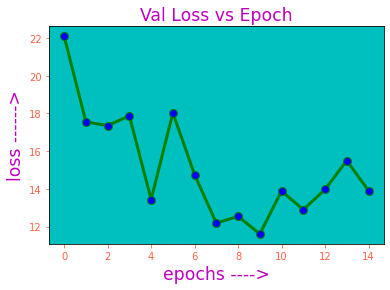

In [25]:
model = Network()
train(model)

**Here we can see that at 10th (9) epoch we get the best loss, so we choose that model for our production.**

In [ ]:
# Saving labels to label value as a json
labels = {'ship':0,'truck':1}
with open('labels.json', 'wb') as iw:
    pickle.dump(labels, iw)

In [ ]:
# prediction function to test
def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((32, 32))])
    image = ToTensor()(image)
    y_result = model(resize(image).unsqueeze(0))
    result_idx = torch.round(y_result)
    for key, value in labels.items():
        if(value == result_idx):
            vehicle = key
            break
    return vehicle